FASE 3

- Los casos de rabia van a ser nodos nuevamente.
- Se va a crear una relacion bidireccional de proximidad desde las cuadras hacia puestos de salud, torrenteras, casos de rabia pero se pone como atributo de la relacion la distancia.
- Para las etiquetas solo se tomara en cuenta los casos de vacunacion que esten dentro de una cuadra y solo tendra como relacion con esa cuadra y la distancia 0.
- Los casos de rabia que no esten dentro de una cuadra se creara una relacion de proximidad con el atributo de distancia
- Se separaran lo datos del 2015 hasta el 2018 para entrenamiento, para validacion 2019 hasta el 2020 y test 2021 hasta 2023 
- Vamos a crear un grafo por año

Posiblemente se agregara despues
- clusterizacion con kmeans
- cross validation

In [561]:
pip install pyreadr pandas torch fastkml torch_geometric folium geopandas

Note: you may need to restart the kernel to use updated packages.


In [562]:
import pandas as pd

In [563]:
# PUESTOS DE SALUD
df_health_posts = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Health_centers_AQP/Puestos_de_salud_APQ_12ene2024.csv", sep=";")
print(df_health_posts.shape)
df_health_posts.head()

(83, 11)


,cluster,n_microred,microred,name,lat,long,y_proj,x_proj,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,22.0,20,MARITZA CAMPOS,C.S. MARITZA CAMPO DIAZ,-16.351375,-71.562525,-1935159.862,2835969.968,NaN,NaN,NaN
1,26.0,20,MARITZA CAMPOS,P.S. CIUDAD MUNICIPAL,-16.325474,-71.594062,-1931722.877,2832729.607,NaN,NaN,NaN
2,22.0,20,MARITZA CAMPOS,P.S. PERUARBO,-16.345310,-71.600061,-1933977.297,2831792.294,NaN,NaN,NaN
3,24.0,20,MARITZA CAMPOS,P.S. NAZARENO,-16.328171,-71.549513,-1932597.555,2837747.160,NaN,NaN,NaN
4,5.0,1,FRANCISCO BOLOGNESI,C.S. FRANCISCO BOLOGNESI,-16.354767,-71.542092,-1935814.847,2838243.050,NaN,NaN,NaN


In [564]:
# TORRENTERAS
df_water_channels = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Water_channels_AQP/Hidrografia_AQP_18ene2024.csv", sep=";")
df_water_channels.head()

,type,ident,lat,long,y_proj,x_proj
0,Rios_Principales,r_prin_001,,,-1.516416e+00,2.076337e+07
1,Rios_Principales,r_prin_001,-16.30381616,-71.48611168,-1.930532e+06,2.845257e+06
2,Rios_Principales,r_prin_001,-16.30379005,-71.48621225,-1.930528e+06,2.845246e+06
3,Rios_Principales,r_prin_001,-16.30376392,-71.48631287,-1.930523e+06,2.845235e+06
4,Rios_Principales,r_prin_001,-16.30376396,-71.48641297,-1.930522e+06,2.845224e+06


In [565]:
#  NIVEL SOCIO-ECONOMICO
df_economic_income_1 = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Economic_income_AQP/Economic_income_cluster/Ecom_cluster_22_10may2023.csv", sep=";")
df_economic_income_2 = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Economic_income_AQP/Economic_income_cluster/Ecom_cluster_23_21feb2023.csv", sep=";")
df_economic_income_3 = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Economic_income_AQP/Economic_income_cluster/Ecom_cluster_24_21feb2023.csv", sep=";")
df_economic_income_4 = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Economic_income_AQP/Economic_income_cluster/Ecom_cluster_25_21feb2023.csv", sep=";")
df_economic_income_5 = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Economic_income_AQP/Economic_income_cluster/Ecom_cluster_26_21feb2023.csv", sep=";")
df_economic_income_6 = pd.read_csv("~/Descargas/SPATIAL_DATA_AQP/Economic_income_AQP/Economic_income_cluster/Ecom_cluster_27_21feb2023.csv", sep=";")
df_economic_income = pd.concat([df_economic_income_1, df_economic_income_2, df_economic_income_3, df_economic_income_4, df_economic_income_5, df_economic_income_6], ignore_index=True)
df_economic_income.head()

,ident,lat,long,y_proj,x_proj,ingreso_economico
0,1.4.54-1,,,-1.516416e+00,2.076337e+07,B
1,1.4.54-1,-16.3619287,-71.56312249,-1.936392e+06,2.835765e+06,B
2,1.4.54-1,-16.36042421,-71.56334575,-1.936212e+06,2.835759e+06,B
3,1.4.54-1,-16.36114067,-71.56646806,-1.936257e+06,2.835396e+06,B
4,1.4.54-1,-16.36256118,-71.5660744,-1.936429e+06,2.835422e+06,B


In [566]:
# RABIA
import os
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Ruta a la carpeta con archivos KML
folder_path = "/home/pantro/Descargas/KML_casos_rabia/"
kml_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".kml")])

# Namespace usado en KML
ns = {"kml": "http://www.opengis.net/kml/2.2"}

features = []

for filename in kml_files:
    filepath = os.path.join(folder_path, filename)
    try:
        year = int(filename.replace(".kml", ""))
    except ValueError:
        continue  # omite archivos mal nombrados

    tree = ET.parse(filepath)
    root = tree.getroot()

    placemarks = root.findall(".//kml:Placemark", ns)
    for pm in placemarks:
        coord_tag = pm.find(".//kml:coordinates", ns)
        name_tag = pm.find("kml:name", ns)
        if coord_tag is not None:
            coords_text = coord_tag.text.strip()
            try:
                lon, lat, *_ = map(float, coords_text.split(','))
                name = name_tag.text.strip() if name_tag is not None else None
                features.append({
                    "name": name,
                    "anio": year,
                    "geometry": Point(lon, lat),
                })
            except ValueError:
                continue

# Crear GeoDataFrame
gdf_rabies = gpd.GeoDataFrame(features, crs="EPSG:4326")

# Mostrar
print(gdf_rabies.shape)
gdf_rabies.head()

# Si quieres guardar como GeoJSON
# gdf.to_file("casos_rabia_completo.geojson", driver="GeoJSON")

(398, 3)


,name,anio,geometry
0,53,2015,POINT (-71.51186 -16.36774)
1,73,2015,POINT (-71.50151 -16.37566)
2,92,2015,POINT (-71.50128 -16.39534)
3,101,2015,POINT (-71.52681 -16.41053)
4,103,2015,POINT (-71.51339 -16.40597)


## Preprosesamiento

In [567]:
import pandas as pd
import geopandas as gpd
import torch
from torch_geometric.data import HeteroData
from geopy.distance import geodesic
from shapely.geometry import Point, Polygon, LineString

In [568]:
# PUESTOS DE SALUD
# Suponiendo que df_health_posts tiene columnas 'lat' y 'long'
gdf_health_posts = gpd.GeoDataFrame(
    df_health_posts,
    geometry=gpd.points_from_xy(df_health_posts['long'], df_health_posts['lat']),
    crs="EPSG:4326"
)
# Filtrar filas: asegurarse que 'cluster' sea un número (ignorar NaNs o strings)
gdf_health_posts = gdf_health_posts[pd.to_numeric(gdf_health_posts['cluster'], errors='coerce').notnull()]

# Convertir 'cluster' a numérico si aún no lo es
gdf_health_posts['cluster'] = gdf_health_posts['cluster'].astype(int)

# Seleccionar solo las columnas deseadas
gdf_health_posts = gdf_health_posts[['cluster', 'n_microred', 'name', 'lat', 'long', 'geometry']]
print(gdf_health_posts.shape)
gdf_health_posts.head()

(77, 6)


,cluster,n_microred,name,lat,long,geometry
0,22,20,C.S. MARITZA CAMPO DIAZ,-16.351375,-71.562525,POINT (-71.56252 -16.35137)
1,26,20,P.S. CIUDAD MUNICIPAL,-16.325474,-71.594062,POINT (-71.59406 -16.32547)
2,22,20,P.S. PERUARBO,-16.345310,-71.600061,POINT (-71.60006 -16.34531)
3,24,20,P.S. NAZARENO,-16.328171,-71.549513,POINT (-71.54951 -16.32817)
4,5,1,C.S. FRANCISCO BOLOGNESI,-16.354767,-71.542092,POINT (-71.54209 -16.35477)


In [569]:
# TORRENTERAS
# Eliminar filas vacías (sin coordenadas)
df_water_channels_clean = df_water_channels[
    (df_water_channels["lat"].str.strip() != '') &
    (df_water_channels["long"].str.strip() != '')
]
# Crear geometrías LineString por grupo
lineas = (
    df_water_channels_clean.groupby("ident")
    .apply(lambda group: LineString(zip(group["long"], group["lat"])))
    .reset_index(name="geometry")
)

# Convertir a GeoDataFrame
gdf_water_channels = gpd.GeoDataFrame(lineas, geometry="geometry", crs="EPSG:4326")
print(gdf_water_channels.shape)
gdf_water_channels.head()

/tmp/ipykernel_26661/627060655.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: LineString(zip(group["long"], group["lat"])))


(218, 2)


,ident,geometry
0,r_prin_001,"LINESTRING (-71.48611 -16.30382, -71.48621 -16..."
1,r_prin_002,"LINESTRING (-71.43686 -16.42426, -71.43687 -16..."
2,r_prin_003,"LINESTRING (-71.41278 -16.57048, -71.41280 -16..."
3,r_prin_004,"LINESTRING (-71.43694 -16.49497, -71.43696 -16..."
4,torr_001,"LINESTRING (-71.46112 -16.36777, -71.46113 -16..."


In [570]:
#------------------------------
# AREAS - NIVEL SOCIECONOMICO
# ------------------------------
# Eliminar filas vacías (sin coordenadas)
df_economic_income_clean = df_economic_income[
    (df_economic_income["lat"].str.strip() != '') &
    (df_economic_income["long"].str.strip() != '')
].copy()

# Agrupar por 'ident' (ID de cuadra) y construir polígonos
area_polys = df_economic_income_clean.groupby("ident").apply(
    lambda g: pd.Series({
        "geometry": Polygon(zip(g["long"], g["lat"])),
        "ingreso_economico": g["ingreso_economico"].unique()[0]  # único valor
    })
).reset_index()
area_polys.columns = ["area_id", "geometry", "ingreso_economico"]

# Adicionando una columna "ingreso_economico_num" con datos numericos para poder analizar esa columna
# Optamos por cambiar los datos de letras a numeros en ves de utilizar ON-HOT ya que en one-hot no permanece el orden y en lo numero si.
# Despues se puede probar con one-hot para ver que sucede
print(area_polys["ingreso_economico"].value_counts())
map_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}# Mapeo de categorías a valores ordinales
area_polys["ingreso_economico_num"] = area_polys["ingreso_economico"].map(map_dict)# Crear nueva columna ordinal

# Crear GeoDataFrame con polígonos
gdf_economic_income = gpd.GeoDataFrame(area_polys, geometry="geometry", crs="EPSG:4326")
print(gdf_economic_income.shape)
gdf_economic_income.head()

#--------------------------------------------------------------
# - Distancia minima del AREA a la TORRENTERA (min_distance_water_channel)
#--------------------------------------------------------------
gdf_economic_income = gdf_economic_income.to_crs(epsg=32719)
gdf_water_channels = gdf_water_channels.to_crs(epsg=32719)
# sjoin_nearest devuelve el área con la torrentera más cercana
gdf_nearest = gdf_economic_income.sjoin_nearest(
    gdf_water_channels,
    how="left", 
    distance_col="min_distance_water_channel"
)
gdf_economic_income["min_distance_water_channel"] = gdf_nearest["min_distance_water_channel"]
print("Datos estadisticos de la distancia minima del AREA hacia la TORRENTERA")
stats = gdf_economic_income["min_distance_water_channel"].describe()
print(stats)
# Escogemos el radio de 250 por que cubre la mayoría de las áreas (aproximadamente 50% y 60%) y no es demasiado grande
print("=== AREA_WATER_CHANNEL_RADIUS = 250 ===")

gdf_economic_income.head()

/tmp/ipykernel_26661/1759772021.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  area_polys = df_economic_income_clean.groupby("ident").apply(


ingreso_economico
E    2619
D    1057
C     213
B      41
Name: count, dtype: int64
(4296, 4)
Datos estadisticos de la distancia minima del AREA hacia la TORRENTERA
count    4296.000000
mean      217.986800
std       270.888618
min         0.000000
25%        49.879799
50%       135.069828
75%       283.016811
max      2481.095996
Name: min_distance_water_channel, dtype: float64
=== AREA_WATER_CHANNEL_RADIUS = 250 ===


,area_id,geometry,ingreso_economico,ingreso_economico_num,min_distance_water_channel
0,1.4.100-1,"POLYGON ((224268.545 8190480.422, 224175.196 8...",D,4.0,1014.663899
1,1.4.100-10,"POLYGON ((223983.171 8191303.516, 223985.935 8...",D,4.0,415.993967
2,1.4.100-11,"POLYGON ((223991.362 8191312.242, 224167.947 8...",D,4.0,476.290826
3,1.4.100-12,"POLYGON ((223736.505 8191347.126, 223726.379 8...",D,4.0,339.202959
4,1.4.100-2,"POLYGON ((223940.104 8190652.198, 223924.309 8...",D,4.0,953.564779


## Solo los puestos de salud y los casos de rabia que estan dentro del cluster

In [571]:
# Filtrar puestos de salud y casos de rabia solo para el cluster 27
df_cluster_1 = pd.read_csv("/home/pantro/Descargas/SPATIAL_DATA_AQP/Clusters_AQP/Limites_Cluster_22_09may2025.csv", sep=";")
df_cluster_2 = pd.read_csv("/home/pantro/Descargas/SPATIAL_DATA_AQP/Clusters_AQP/Limites_Cluster_23_09may2025.csv", sep=";")
df_cluster_3 = pd.read_csv("/home/pantro/Descargas/SPATIAL_DATA_AQP/Clusters_AQP/Limites_Cluster_24_09may2025.csv", sep=";")
df_cluster_4 = pd.read_csv("/home/pantro/Descargas/SPATIAL_DATA_AQP/Clusters_AQP/Limites_Cluster_25_09may2025.csv", sep=";")
df_cluster_5 = pd.read_csv("/home/pantro/Descargas/SPATIAL_DATA_AQP/Clusters_AQP/Limites_Cluster_26_09may2025.csv", sep=";")
df_cluster_6 = pd.read_csv("/home/pantro/Descargas/SPATIAL_DATA_AQP/Clusters_AQP/Limites_Cluster_27_09may2025.csv", sep=";")
# Unir los DataFrames
df_cluster = pd.concat([df_cluster_1, df_cluster_2, df_cluster_3, df_cluster_4, df_cluster_5, df_cluster_6], ignore_index=True)
# 1. Eliminar filas sin coordenadas (NaN o vacías)
df_cluster_clean = df_cluster[
    (df_cluster["lat"].str.strip() != '') &
    (df_cluster["long"].str.strip() != '')
]

# 2. Asegurar que las coordenadas sean float
df_cluster_clean["lat"] = df_cluster_clean["lat"].astype(float)
df_cluster_clean["long"] = df_cluster_clean["long"].astype(float)

# 3. Agrupar por 'ident' y construir polígonos
cluster_polys = df_cluster_clean.groupby("ident").apply(
    lambda g: Polygon(zip(g["long"], g["lat"]))
).reset_index(name="geometry")

# 4. Crear GeoDataFrame
gdf_cluster = gpd.GeoDataFrame(cluster_polys, geometry="geometry", crs="EPSG:4326")
print("CLUSTER")
print(gdf_cluster.head())

# OBTENER SOLO LOS PUESTOS DE SALUD DENTRO DEL CLUSTER
gdf_health_posts = gpd.sjoin(
    gdf_health_posts,
    gdf_cluster,
    how="inner",
    predicate="intersects"
)
print("---------------------------------------")
print("PUESTOS DE SALUD DEL SECTOR")
print(gdf_health_posts.shape)
print(gdf_health_posts.head())
gdf_rabies = gpd.sjoin(
    gdf_rabies,
    gdf_cluster,
    how="inner",
    predicate="intersects"
)
print("---------------------------------------")
print("CASOS DE RABIA DEL SECTOR")
print(gdf_rabies.shape)
print(gdf_rabies.head())

CLUSTER
         ident                                           geometry
0  ZAMACOLA_01  POLYGON ((-71.54220 -16.32096, -71.54209 -16.3...
1  ZAMACOLA_02  POLYGON ((-71.56913 -16.32129, -71.56928 -16.3...
2  ZAMACOLA_03  POLYGON ((-71.57338 -16.32124, -71.57415 -16.3...
3  ZAMACOLA_04  POLYGON ((-71.60649 -16.32654, -71.60492 -16.3...
4  ZAMACOLA_05  POLYGON ((-71.61663 -16.32034, -71.61677 -16.3...
---------------------------------------
PUESTOS DE SALUD DEL SECTOR
(4, 8)
   cluster  n_microred                     name        lat       long  \
0       22          20  C.S. MARITZA CAMPO DIAZ -16.351375 -71.562525   
1       26          20    P.S. CIUDAD MUNICIPAL -16.325474 -71.594062   
2       22          20            P.S. PERUARBO -16.345310 -71.600061   
3       24          20            P.S. NAZARENO -16.328171 -71.549513   

                      geometry  index_right        ident  
0  POINT (-71.56252 -16.35137)            5  ZAMACOLA_06  
1  POINT (-71.59406 -16.32547)       

/tmp/ipykernel_26661/30325034.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_clean["lat"] = df_cluster_clean["lat"].astype(float)
/tmp/ipykernel_26661/30325034.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_clean["long"] = df_cluster_clean["long"].astype(float)
/tmp/ipykernel_26661/30325034.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded f

In [572]:
#--------------------------------------------------------------
# - Distancia minima al del AREA hacia el PUESTO DE SALUD (min_distance_health_post)
#   * NOTA: El codigo va aqui por que aqui recien sabemos cuales puestos de salud son de la zona que vamos a trabajar
#--------------------------------------------------------------------
# Asegúrate de que ambos estén en la misma proyección 
gdf_economic_income = gdf_economic_income.to_crs(epsg=32719)
gdf_health_posts = gdf_health_posts.to_crs(epsg=32719)
# Eliminar columnas que pueden causar problemas
gdf_economic_income = gdf_economic_income.drop(columns=["index_left", "index_right"], errors="ignore")
gdf_health_posts = gdf_health_posts.drop(columns=["index_left", "index_right"], errors="ignore")
# Hacer el join espacial con el puesto de salud más cercano
gdf_nearest = gdf_economic_income.sjoin_nearest(
    gdf_health_posts,
    how="left",
    distance_col="min_distance_health_post"
)
gdf_economic_income["min_distance_health_post"] = gdf_nearest["min_distance_health_post"]
stats = gdf_economic_income["min_distance_health_post"].describe()
print(stats)
# Se decide utilizar el radio de 2000m por que segun lo datos obtenido cubre alrededor del 60–70% de las áreas (hasta el tercer cuartil)
print("=== AREA_HEALTH_POST_RADIUS = 2000 ===")
gdf_economic_income.head()

count    4296.000000
mean     1745.567669
std      1002.094651
min         0.000000
25%      1028.346285
50%      1581.590831
75%      2262.663550
max      5102.326311
Name: min_distance_health_post, dtype: float64
=== AREA_HEALTH_POST_RADIUS = 2000 ===


,area_id,geometry,ingreso_economico,ingreso_economico_num,min_distance_water_channel,min_distance_health_post
0,1.4.100-1,"POLYGON ((224268.545 8190480.422, 224175.196 8...",D,4.0,1014.663899,1815.732788
1,1.4.100-10,"POLYGON ((223983.171 8191303.516, 223985.935 8...",D,4.0,415.993967,1610.846277
2,1.4.100-11,"POLYGON ((223991.362 8191312.242, 224167.947 8...",D,4.0,476.290826,1787.481405
3,1.4.100-12,"POLYGON ((223736.505 8191347.126, 223726.379 8...",D,4.0,339.202959,1521.736024
4,1.4.100-2,"POLYGON ((223940.104 8190652.198, 223924.309 8...",D,4.0,953.564779,1778.237966


In [573]:
'''
import folium
from folium import FeatureGroup, LayerControl, Marker, PolyLine, GeoJson
import geopandas as gpd

# Convertir a "4326" para poder visualizar en el mapa
gdf_economic_income = gdf_economic_income.to_crs(epsg=4326)
gdf_water_channels = gdf_water_channels.to_crs(epsg=4326)
gdf_health_posts = gdf_health_posts.to_crs(epsg=4326)

# Mapa base centrado en Arequipa
m = folium.Map(location=[-16.3989, -71.5350], zoom_start=12)

# === CAPA 1: Casos de RABIA (Points) ===
fg_rabies = FeatureGroup(name="Casos de Rabia")
for _, row in gdf_rabies.iterrows():
    Marker(
        location=[row.geometry.y, row.geometry.x],
        popup="Caso de rabia",
        icon=folium.Icon(color="red", icon="exclamation-sign")
    ).add_to(fg_rabies)
fg_rabies.add_to(m)

# === CAPA 2: Nivel Socioeconómico (Polygons) ===
fg_income = FeatureGroup(name="Nivel Socioeconómico")
GeoJson(
    gdf_economic_income,
    name="Nivel Socioeconómico",
    style_function=lambda x: {
        'fillColor': '#00b894',
        'color': '#2d3436',
        'weight': 1,
        'fillOpacity': 0.4,
    },
    tooltip=folium.GeoJsonTooltip(fields=["area_id"])
).add_to(fg_income)
fg_income.add_to(m)

# === CAPA 3: Puestos de Salud (Points) ===
fg_salud = FeatureGroup(name="Puestos de Salud")
for _, row in gdf_health_posts.iterrows():
    Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["name"],
        icon=folium.Icon(color="blue", icon="plus-sign")
    ).add_to(fg_salud)
fg_salud.add_to(m)

# === CAPA 4: Torrenteras (LineStrings) ===
fg_torrenteras = FeatureGroup(name="Torrenteras")
GeoJson(
    gdf_water_channels,
    name="Torrenteras",
    style_function=lambda x: {
        'color': '#6c5ce7',
        'weight': 2,
    },
    tooltip=folium.GeoJsonTooltip(fields=["ident"])
).add_to(fg_torrenteras)
fg_torrenteras.add_to(m)

# === CAPA 5: Clústeres (Polygons) ===
fg_cluster = FeatureGroup(name="Clústeres")
GeoJson(
    gdf_cluster,
    name="Clústeres",
    style_function=lambda x: {
        'fillColor': '#ffeaa7',
        'color': '#d35400',
        'weight': 2,
        'fillOpacity': 0.3,
    },
    tooltip=folium.GeoJsonTooltip(fields=["ident"])
).add_to(fg_cluster)
fg_cluster.add_to(m)

# === Control de capas ===
folium.LayerControl(collapsed=False).add_to(m)

# === Guardar o mostrar ===
m.save("mapa_solo_objetivo_fase3.html")
'''

'\nimport folium\nfrom folium import FeatureGroup, LayerControl, Marker, PolyLine, GeoJson\nimport geopandas as gpd\n\n# Convertir a "4326" para poder visualizar en el mapa\ngdf_economic_income = gdf_economic_income.to_crs(epsg=4326)\ngdf_water_channels = gdf_water_channels.to_crs(epsg=4326)\ngdf_health_posts = gdf_health_posts.to_crs(epsg=4326)\n\n# Mapa base centrado en Arequipa\nm = folium.Map(location=[-16.3989, -71.5350], zoom_start=12)\n\n# === CAPA 1: Casos de RABIA (Points) ===\nfg_rabies = FeatureGroup(name="Casos de Rabia")\nfor _, row in gdf_rabies.iterrows():\n    Marker(\n        location=[row.geometry.y, row.geometry.x],\n        popup="Caso de rabia",\n        icon=folium.Icon(color="red", icon="exclamation-sign")\n    ).add_to(fg_rabies)\nfg_rabies.add_to(m)\n\n# === CAPA 2: Nivel Socioeconómico (Polygons) ===\nfg_income = FeatureGroup(name="Nivel Socioeconómico")\nGeoJson(\n    gdf_economic_income,\n    name="Nivel Socioeconómico",\n    style_function=lambda x: {\n    

anio
2016    32
2017    22
2018    23
2019    17
2020     7
2021    44
2022    11
2023     3
2024     2
Name: count, dtype: int64


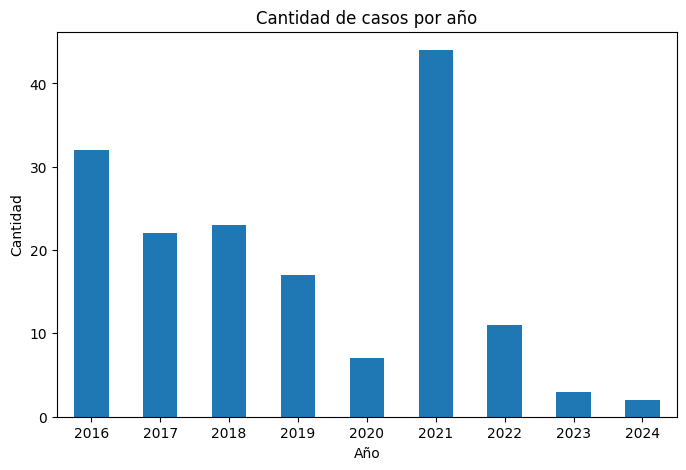

In [574]:
# Analizar cantidad de casos de rabia para ver si separamos los casos de rabia de la pandemia 2020 y 2021
import matplotlib.pyplot as plt

# Conteo de registros por año (ordenado)
conteo = gdf_rabies["anio"].value_counts().sort_index()

print(conteo)

# Gráfico de barras
conteo.plot(kind="bar", figsize=(8,5))
plt.title("Cantidad de casos por año")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)  # Mantener etiquetas de años horizontales
plt.show()

# NOTA: No conviene separar lo datos de la pandemia, trabajaremos con todo

In [575]:
#------------------------------
# MOTIVO: Se separo de esta amnera deacuerdo a la cantidad de casos de rabia presentados para que los conjuntos sean algo equitativos.
# - La validación cae en años de la pandemia (para probar robustez ante irregularidades).
# - El test refleja los años más recientes (baja incidencia, pero epidemiológicamente más interesantes).
#------------------------------
#- SEPARAR CASOS DE RABIA DEL 2016-2019 PARA TRAIN
gdf_rabies_train = gdf_rabies[(gdf_rabies["anio"] > 2015) & (gdf_rabies["anio"] < 2020)]
print("Cantidad de casos de rabia 2016-2019: ",len(gdf_rabies_train))
print(gdf_rabies_train["anio"].value_counts())

#- SEPARAR CASOS DE RABIA DEL 2020-2021 PARA VAL 
gdf_rabies_val = gdf_rabies[(gdf_rabies["anio"] > 2018) & (gdf_rabies["anio"] < 2022)]
print("Cantidad de casos de rabia 2020-2021: ",len(gdf_rabies_val))
print(gdf_rabies_val["anio"].value_counts())

#- SEPARAR CASOS DE RABIA DEL 2022-2024 PARA TEST
gdf_rabies_test = gdf_rabies[(gdf_rabies["anio"] > 2020)]
print("Cantidad de registros 2022-2024: ",len(gdf_rabies_test))
print(gdf_rabies_test["anio"].value_counts())

Cantidad de casos de rabia 2016-2019:  94
anio
2016    32
2018    23
2017    22
2019    17
Name: count, dtype: int64
Cantidad de casos de rabia 2020-2021:  68
anio
2021    44
2019    17
2020     7
Name: count, dtype: int64
Cantidad de registros 2022-2024:  60
anio
2021    44
2022    11
2023     3
2024     2
Name: count, dtype: int64


# Generar el grafo para TRAIN, VAL y TEST

In [576]:
import pandas as pd
import geopandas as gpd
import torch
from torch_geometric.data import HeteroData
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#******************************************************
# TRAIN
gdf_rabies = gdf_rabies_test.copy()
CURRENT_YEAR = 2023
NEXT_YEAR = 2024
#******************************************************

# Cambiar a "EPSG:32719"
gdf_rabies_proj = gdf_rabies.to_crs("EPSG:32719")
gdf_economic_income_proj = gdf_economic_income.to_crs("EPSG:32719")
gdf_health_posts_proj = gdf_health_posts.to_crs("EPSG:32719")
gdf_water_channels_proj = gdf_water_channels.to_crs("EPSG:32719")

# --------------------------------------------
# CARGA DE DATOS (GeoDataFrames preprocesados):
# ----------------------------------------------
# - gdf_economic_income: areass como POLYGON
# - gdf_health_posts: centros de salud como POINT
# - gdf_water_channels: torrenteras como LINESTRING
# - gdf_rabies: casos de rabia como POINT + año
# ---------------------------

# Asegurar proyección métrica
areas = gdf_economic_income_proj.copy()
rabies_current_year = gdf_rabies_proj[gdf_rabies_proj["anio"] == CURRENT_YEAR].copy()
print(f"rabies_current_year: {len(rabies_current_year)}")
rabies_next_year    = gdf_rabies_proj[gdf_rabies_proj["anio"] == NEXT_YEAR].copy()
print(f"rabies_next_year: {len(rabies_next_year)}")
health_posts = gdf_health_posts_proj.copy()
water_channels = gdf_water_channels_proj.copy()

rabies_current_year: 3
rabies_next_year: 2


In [577]:
#--------------------------------------------------------------
# - Distancia minima a un caso de rabia (min_distance_rabies_case)
#   * NOTA: El codigo va aqui por que aqui recien sabemos cuales son los casos de rabia por año 
#--------------------------------------------------------------------
# Eliminar columnas que pueden causar problemas
rabies_current_year = rabies_current_year.drop(columns=["index_left", "index_right"], errors="ignore")
# Hacer sjoin_nearest, no es necesario lsuffix/rsuffix
gdf_nearest = areas.sjoin_nearest(
    rabies_current_year,
    how="left",
    distance_col="min_distance_rabies"
)
# Crear columna con el índice original de gdf_economic_income
gdf_nearest["poly_index"] = gdf_nearest.index
# Agrupar por cada polígono y quedarse solo con la distancia mínima
gdf_min_distance = gdf_nearest.groupby("poly_index")["min_distance_rabies"].min()
# Agregar al GeoDataFrame original
areas["min_distance_rabies"] = areas.index.map(gdf_min_distance)
stats = areas["min_distance_rabies"].describe()
print(stats)
#Se decide utilizar el radio de 400m por que segun lo datos estadisticos obtenido un poco mas del 25% del área 
# y es lo que nosotros pensamos que un caso de rabia podria propagarse son como aproximadamente 4 cuadras
print("=== AREA_RABIES_CASE_RADIUS = 400 ===")
print("*************************************************************************************")
#-----------------------------------------------------
# - Cantidad de casos en el año (num_rabies_case_year)
#-----------------------------------------------------
# Spatial join: asigna casos a polígonos
rabies_with_area = gpd.sjoin(
    rabies_current_year, 
    areas, 
    how="left", 
    predicate="within"
)
# Contar casos por área
cases_per_area = rabies_with_area.groupby("index_right").size()
# Crear columna en areas
areas["num_rabies_case_year"] = areas.index.map(cases_per_area).fillna(0).astype(int)

print(areas["num_rabies_case_year"].value_counts())

areas.head()

count    4296.000000
mean     2037.527986
std      1110.964859
min         0.000000
25%      1168.238249
50%      1994.915730
75%      2709.175791
max      5553.922846
Name: min_distance_rabies, dtype: float64
=== AREA_RABIES_CASE_RADIUS = 400 ===
*************************************************************************************
num_rabies_case_year
0    4294
1       2
Name: count, dtype: int64


,area_id,geometry,ingreso_economico,ingreso_economico_num,min_distance_water_channel,min_distance_health_post,min_distance_rabies,num_rabies_case_year
0,1.4.100-1,"POLYGON ((224268.545 8190480.422, 224175.196 8...",D,4.0,1014.663899,1815.732788,1927.484649,0
1,1.4.100-10,"POLYGON ((223983.171 8191303.516, 223985.935 8...",D,4.0,415.993967,1610.846277,2652.028564,0
2,1.4.100-11,"POLYGON ((223991.362 8191312.242, 224167.947 8...",D,4.0,476.290826,1787.481405,2757.619894,0
3,1.4.100-12,"POLYGON ((223736.505 8191347.126, 223726.379 8...",D,4.0,339.202959,1521.736024,2814.913459,0
4,1.4.100-2,"POLYGON ((223940.104 8190652.198, 223924.309 8...",D,4.0,953.564779,1778.237966,2114.615514,0


In [578]:
#--------------------------------------
# Crear la etiqueta del problema
#--------------------------------------
# Eliminar columnas que pueden causar problemas
rabies_next_year = rabies_next_year.drop(columns=["index_left", "index_right"], errors="ignore")
# Spatial join: asigna cada caso de rabia del "año siguiente" al polígono en que cae
rabies_with_area_next = gpd.sjoin(
    rabies_next_year,
    areas,
    how="left",
    predicate="within"
)
# Contar casos por polígono
cases_per_area_next = rabies_with_area_next.groupby("index_right").size()
# Crear etiqueta binaria: 1 si hay >=1 caso, 0 si no
areas["label_rabies_next_year"] = areas.index.map(lambda i: 1 if i in cases_per_area_next.index else 0)

areas["label_rabies_next_year"].value_counts()

label_rabies_next_year
0    4295
1       1
Name: count, dtype: int64

In [579]:
# ---------------------------
# PARÁMETROS CONFIGURABLES
# ---------------------------

# Escogemos el radio de 250 por que cubre la mayoría de las áreas (aproximadamente 50% y 70%) y no es demasiado grande
AREA_WATER_CHANNEL_RADIUS = 250 # podriamos probar luego con 300

# Se decide utilizar el radio de 2000m por que segun lo datos obtenido cubre alrededor del 60–70% de las áreas (hasta el tercer cuartil)
AREA_HEALTH_POSTS_RADIUS = 2000

#Se decide utilizar el radio de 400m por que segun lo datos estadisticos obtenido un poco mas del 25% del área 
# y es lo que nosotros pensamos que un caso de rabia podria propagarse son como aproximadamente 4 cuadras
AREA_RABIES_CASE_RADIUS = 400 

AREA_NEIGHBOR_RADIUS = 200  # radio en metros para definir los VECINOS entre AREAS

### CREAR NODOS

In [580]:
# ---------------------------
# CREAR GRAFO HETEROGÉNEO
# ---------------------------

data = HeteroData()

# NODO PUESTO DE SALUD
#-----------------------
# No guardamos lat/long como features
# Guardamos cluster y n_microred
# A pesar que no tenga ninguna feature aporta como ancla en el modelo

hp_feature_columns = ["cluster", "n_microred"]
scaler = MinMaxScaler()
health_post_features = scaler.fit_transform(health_posts[hp_feature_columns])
data["health_post"].x = torch.tensor(health_post_features, dtype=torch.float)
data['health_post'].feature_columns = hp_feature_columns
data["health_post"].name = health_posts["name"].tolist()
data["health_post"].node_index = health_posts.index.to_list()

# NODO TORRENTERA
#-----------------------
num_wc = len(water_channels)
data["water_channel"].x = torch.zeros((num_wc, 1))  # placeholder
data["water_channel"].ident = water_channels["ident"].tolist()
data["water_channel"].node_index = water_channels.index.to_list()  # <-- guardar índices

# NODO CASOS DE RABIA
#-----------------------
num_rc = len(rabies_current_year)
data["rabies_case"].x = torch.zeros((num_rc, 1))  # placeholder
data["rabies_case"].name = rabies_current_year["name"].tolist()
data["rabies_case"].node_index = rabies_current_year.index.to_list()  # <-- guardar índices

# NODO AREA
#-----------------------
# - Distancia minima al puesto de salud
# - Distancia minima a la torrentera
# - Distancia minima a un caso de rabia
# - Cantidad de casos en el año

# Normalizar
a_feature_columns = ["ingreso_economico_num", "min_distance_water_channel","min_distance_health_post","min_distance_rabies","num_rabies_case_year"]
scaler = MinMaxScaler()
area_features = scaler.fit_transform(areas[a_feature_columns])

data["area"].x = torch.tensor(area_features, dtype=torch.float)
data['area'].feature_columns = a_feature_columns
data["area"].area_id = areas["area_id"].tolist() # Me conviene guardarlo para poder despues relacionar los resultados 
data["area"].node_index = areas.index.to_list()  # <-- Aquí guardar índices reales

## OJO: Solo por esta vez, porque esto debe de manipularse en el modelo
# Crear y guardar etiquetas binarias directamente
#col_idx = feature_columns.index("num_rabies_cases_in_area")
#num_cases_tensor = data['area'].x[:, col_idx]
#data['area'].y = (num_cases_tensor > 0).long()
data['area'].y = torch.tensor(areas[["label_rabies_next_year"]].values, dtype=torch.float) # FLOAT por que BCEWithLogitsLoss

num_pos = torch.sum(data['area'].y).item()
num_total = data['area'].y.size(0)
num_neg = num_total - num_pos
print(f"Positivos (1): {num_pos}")
print(f"Negativos (0): {num_neg}")

Positivos (1): 1.0
Negativos (0): 4295.0


In [581]:
# COMPROBACION DE DATOS
## PARA PROPOSITOS DE VISUALIZACION Y VER QUE TODO VAYA BIEN
#
print("------------------------------------------------------------------")
print("*****************  df_preview_health_post  *************************")
print("------------------------------------------------------------------")
df_preview_health_post = pd.DataFrame({
    "name": data["health_post"].name[:5],
    "node_index": data["health_post"].node_index[:5],
    "cluster": data["health_post"].x[:, 0].tolist(),
    "n_microred": data["health_post"].x[:, 1].tolist()
})

print(df_preview_health_post.head())

print("------------------------------------------------------------------")
print("*****************  df_preview_area  *************************")
print("------------------------------------------------------------------")
df_preview_area = pd.DataFrame({
    "area_id": data["area"].area_id,   # todos
    "node_index": data["area"].node_index,  # todos
    "ingreso_economico_num": data["area"].x[:, 0].tolist(),
    "min_distance_water_channel": data["area"].x[:, 1].tolist(),
    "min_distance_health_post": data["area"].x[:, 2].tolist(),
    "min_distance_rabies": data["area"].x[:, 3].tolist(),
    "num_rabies_case_year": data["area"].x[:, 4].tolist(),
})

print(df_preview_area.head())

------------------------------------------------------------------
*****************  df_preview_health_post  *************************
------------------------------------------------------------------
                      name  node_index  cluster  n_microred
0  C.S. MARITZA CAMPO DIAZ           0      0.0         0.0
1    P.S. CIUDAD MUNICIPAL           1      1.0         0.0
2            P.S. PERUARBO           2      0.0         0.0
3            P.S. NAZARENO           3      0.5         0.0
------------------------------------------------------------------
*****************  df_preview_area  *************************
------------------------------------------------------------------
      area_id  node_index  ingreso_economico_num  min_distance_water_channel  \
0   1.4.100-1           0               0.666667                    0.408958   
1  1.4.100-10           1               0.666667                    0.167665   
2  1.4.100-11           2               0.666667             

In [582]:
# Ejemplo para ver si estan bien los datos
df_preview_area["ingreso_economico_num"].value_counts()

ingreso_economico_num
1.000000    2619
0.666667    1057
0.333333     213
0.000000      41
Name: count, dtype: int64

### CREAR RELACIONES (ARISTAS)

In [583]:
from shapely.geometry import box

# ---------------------------
# area ↔ area (vecinas por distancia entre centroides)
# ---------------------------
# Asegurarse de estar en CRS métrico
assert areas.crs.is_projected, "Reproyecta a CRS en metros antes de calcular distancias."

# Generar relaciones de vecindad
edges = []
distances = []

# Crear índice espacial
sindex = areas.sindex

for i, geom in enumerate(areas.geometry):
    # Bounding box expandida por el radio
    bbox = box(*geom.bounds).buffer(AREA_NEIGHBOR_RADIUS).bounds
    
    # Posibles vecinos (candidatos dentro de la bbox)
    candidate_idx = list(sindex.intersection(bbox))
    
    for j in candidate_idx:
        if i == j:
            continue  # evitar self-loop
        d = geom.distance(areas.geometry.iloc[j])
        if d <= AREA_NEIGHBOR_RADIUS:
            edges.append([i, j])
            distances.append(d)

# Convertir a tensores PyTorch
edge_index = torch.tensor(edges, dtype=torch.long).T   # shape [2, num_edges]
edge_attr  = torch.tensor(distances, dtype=torch.float).unsqueeze(1)  # shape [num_edges, 1]

distances = np.array(edge_attr).reshape(-1,1)
scaler = MinMaxScaler()
edge_attr_norm = scaler.fit_transform(distances)

# Guardar en data
data["area", "neighbor_of", "area"].edge_index = edge_index
data[("area", "neighbor_of", "area")].edge_attr = torch.tensor(edge_attr_norm, dtype=torch.float)

# Revisar si todas las aristas tienen su inversa
edges_set = set(map(tuple, edges))
missing = [(i, j) for (i, j) in edges_set if (j, i) not in edges_set]

print(f"Aristas totales: {len(edges_set)}")
print(f"Aristas sin inversa: {len(missing)}")#Si missing = 0 → tu grafo ya es bidireccional.

Aristas totales: 125132
Aristas sin inversa: 0


In [584]:
# ---------------------------
# area → Torrenteras (con distancia como atributo)
# ---------------------------
edges_area_wc = []
edges_wc_area = []
distances = []

# Índices espaciales
sindex_area = areas.sindex
sindex_wc = water_channels.sindex

for i, geom_area in enumerate(areas.geometry):
    # bounding box expandida por el radio
    bbox = box(*geom_area.bounds).buffer(AREA_WATER_CHANNEL_RADIUS).bounds
    
    # candidatos: torrenteras dentro de la bbox
    candidate_idx = list(sindex_wc.intersection(bbox))
    
    for j in candidate_idx:
        geom_wc = water_channels.geometry.iloc[j]
        d = geom_area.distance(geom_wc)
        if d <= AREA_WATER_CHANNEL_RADIUS:
            edges_area_wc.append([i, j])
            edges_wc_area.append([j, i])
            distances.append(d)

# Convertir a tensores
edge_index_area_wc = torch.tensor(edges_area_wc, dtype=torch.long).T
edge_index_wc_area = torch.tensor(edges_wc_area, dtype=torch.long).T

# Normalizar distancias
scaler = MinMaxScaler()
edge_attr_norm = scaler.fit_transform(np.array(distances).reshape(-1, 1))
edge_attr_tensor = torch.tensor(edge_attr_norm, dtype=torch.float)

# Guardar en HeteroData
data["area", "a_near_wc", "water_channel"].edge_index = edge_index_area_wc
data["area", "a_near_wc", "water_channel"].edge_attr  = edge_attr_tensor
# Como no vamos a utilizar el nodo torrentera como TARGET no es necesario hacerlo bidireccional
data["water_channel", "wc_near_a", "area"].edge_index = edge_index_wc_area
data["water_channel", "wc_near_a", "area"].edge_attr  = edge_attr_tensor 

In [585]:
# ---------------------------
# area → Puesto de salud más cercano y pone la distancia como atributo
# ---------------------------
edges_area_hp = []
edges_hp_area = []
distances = []

# Índices espaciales
sindex_area = areas.sindex
sindex_hp   = health_posts.sindex

for i, geom_area in enumerate(areas.geometry):
    # bounding box expandida por el radio
    bbox = box(*geom_area.bounds).buffer(AREA_HEALTH_POSTS_RADIUS).bounds
    
    # candidatos: puestos dentro de la bbox
    candidate_idx = list(sindex_hp.intersection(bbox))
    
    for j in candidate_idx:
        geom_hp = health_posts.geometry.iloc[j]
        d = geom_area.distance(geom_hp)
        if d <= AREA_HEALTH_POSTS_RADIUS:
            edges_area_hp.append([i, j])
            edges_hp_area.append([j, i])
            distances.append(d)

# Convertir a tensores
edge_index_area_hp = torch.tensor(edges_area_hp, dtype=torch.long).T
edge_index_hp_area = torch.tensor(edges_hp_area, dtype=torch.long).T

# Normalizar distancias
scaler = MinMaxScaler()
edge_attr_norm = scaler.fit_transform(np.array(distances).reshape(-1, 1))
edge_attr_tensor = torch.tensor(edge_attr_norm, dtype=torch.float)

# Guardar en HeteroData
data["area", "reports_to", "health_post"].edge_index = edge_index_area_hp
data["area", "reports_to", "health_post"].edge_attr  = edge_attr_tensor

data["health_post", "receives_reports", "area"].edge_index = edge_index_hp_area
data["health_post", "receives_reports", "area"].edge_attr  = edge_attr_tensor

In [586]:
# ---------------------------
# 🦠 Caso de rabia → area (sjoin espacial)
# ---------------------------
edges_area_rc = []
edges_rc_area = []
distances = []

# Índices espaciales
sindex_area = areas.sindex
sindex_rc = rabies_current_year.sindex

for i, geom_area in enumerate(areas.geometry):
    # Bounding box expandida por el radio
    bbox = box(*geom_area.bounds).buffer(AREA_RABIES_CASE_RADIUS).bounds
    
    # candidatos: casos de rabia dentro de la bbox
    candidate_idx = list(sindex_rc.intersection(bbox))
    
    for j in candidate_idx:
        geom_rc = rabies_current_year.geometry.iloc[j]
        d = geom_area.distance(geom_rc)
        if d <= AREA_RABIES_CASE_RADIUS:
            # Arista area → rabies_case
            edges_area_rc.append([i, j])
            # Arista rabies_case → area
            edges_rc_area.append([j, i])
            distances.append(d)

# Convertir a tensores
edge_index_area_rc = torch.tensor(edges_area_rc, dtype=torch.long).T
edge_index_rc_area = torch.tensor(edges_rc_area, dtype=torch.long).T

# Normalizar distancias
scaler = MinMaxScaler()
edge_attr_norm = scaler.fit_transform(np.array(distances).reshape(-1, 1))
edge_attr_tensor = torch.tensor(edge_attr_norm, dtype=torch.float)

# Guardar en HeteroData
data["area", "a_near_rc", "rabies_case"].edge_index = edge_index_area_rc
data["area", "a_near_rc", "rabies_case"].edge_attr  = edge_attr_tensor

data["rabies_case", "rb_near_a", "area"].edge_index = edge_index_rc_area
data["rabies_case", "rb_near_a", "area"].edge_attr  = edge_attr_tensor

In [587]:
# PARA VERIFICAR LA CANTIDAD DE NODOS Y ARISTAS
#print("Nodos en 'rabies_case':", data["rabies_case"].num_nodes)
print("Nodos en 'area':", data["area"].num_nodes)
print("Relaciones y número de aristas:")
for etype in data.edge_types:
    edge_storage = data[etype]
    print(f"{etype}: num_edges={getattr(edge_storage, 'num_edges', 'unknown')}")

Nodos en 'area': 4296
Relaciones y número de aristas:
('area', 'neighbor_of', 'area'): num_edges=125132
('area', 'a_near_wc', 'water_channel'): num_edges=4603
('water_channel', 'wc_near_a', 'area'): num_edges=4603
('area', 'reports_to', 'health_post'): num_edges=3357
('health_post', 'receives_reports', 'area'): num_edges=3357
('area', 'a_near_rc', 'rabies_case'): num_edges=220
('rabies_case', 'rb_near_a', 'area'): num_edges=220


In [588]:
# ---------------------------
# GUARDAR EL GRAFO
# ---------------------------
torch.save(
    data,
    f"/home/pantro/Documentos/GITHUB/rabies-graph-neural-model/results/fase3/heterograph_{CURRENT_YEAR}.pt"
)
print(f"✅ Grafo heterogéneo del {CURRENT_YEAR} guardado")

✅ Grafo heterogéneo del 2023 guardado


In [589]:
#pip install networkx

## Cargando el grafo guardado

In [590]:
'''
import torch

# Cargar el grafo
data = torch.load("/home/pantro/Documentos/GITHUB/rabies-graph-neural-model/zamacola_heterograph_fase3.pt", weights_only=False)

print("✅ Grafo heterogéneo cargado correctamente")
print(isinstance(data, HeteroData))  # Debería imprimir: True
print(data)
'''

'\nimport torch\n\n# Cargar el grafo\ndata = torch.load("/home/pantro/Documentos/GITHUB/rabies-graph-neural-model/zamacola_heterograph_fase3.pt", weights_only=False)\n\nprint("✅ Grafo heterogéneo cargado correctamente")\nprint(isinstance(data, HeteroData))  # Debería imprimir: True\nprint(data)\n'

# Guardar en formato para Neo4j

In [591]:
'''
import torch
import pandas as pd
import os

def heterodata_to_neo4j_csv(data, output_dir="neo4j_csv"):
    os.makedirs(output_dir, exist_ok=True)

    # Guardar nodos
    for node_type in data.node_types:
        node_data = data[node_type]

        # Asegurarse de que haya atributos
        if hasattr(node_data, 'x') and node_data.x is not None:
            df = pd.DataFrame(node_data.x.cpu().numpy())
            df.columns = [f"attr{i}" for i in range(df.shape[1])]
        else:
            num_nodes = data[node_type].num_nodes
            df = pd.DataFrame(index=range(num_nodes))  # Nodo sin atributos

        # Agregar columna de ID (requerida por Neo4j)
        df[f"{node_type}_id"] = df.index
        df.to_csv(os.path.join(output_dir, f"nodes_{node_type}.csv"), index=False)
        print(f"Guardado nodos: {node_type} -> {df.shape}")

    # Guardar aristas
    for edge_type in data.edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = data[edge_type].edge_index.cpu().numpy()

        edge_df = pd.DataFrame({
            "source": edge_index[0],
            "target": edge_index[1],
            "type": rel_type,
            "source_type": src_type,
            "target_type": dst_type
        })

        # Agregar atributos de aristas si existen
        if 'edge_attr' in data[edge_type]:
            edge_attrs = data[edge_type]['edge_attr'].cpu().numpy()
            edge_attr_df = pd.DataFrame(edge_attrs)
            edge_df = pd.concat([edge_df, edge_attr_df], axis=1)

        filename = f"edges_{src_type}_{rel_type}_{dst_type}.csv"
        edge_df.to_csv(os.path.join(output_dir, filename), index=False)
        print(f"Guardado aristas: {edge_type} -> {edge_df.shape}")

    print("\n✅ Exportación completa. Los archivos están en:", os.path.abspath(output_dir))


# Llamar a la función
heterodata_to_neo4j_csv(data)
'''

'\nimport torch\nimport pandas as pd\nimport os\n\ndef heterodata_to_neo4j_csv(data, output_dir="neo4j_csv"):\n    os.makedirs(output_dir, exist_ok=True)\n\n    # Guardar nodos\n    for node_type in data.node_types:\n        node_data = data[node_type]\n\n        # Asegurarse de que haya atributos\n        if hasattr(node_data, \'x\') and node_data.x is not None:\n            df = pd.DataFrame(node_data.x.cpu().numpy())\n            df.columns = [f"attr{i}" for i in range(df.shape[1])]\n        else:\n            num_nodes = data[node_type].num_nodes\n            df = pd.DataFrame(index=range(num_nodes))  # Nodo sin atributos\n\n        # Agregar columna de ID (requerida por Neo4j)\n        df[f"{node_type}_id"] = df.index\n        df.to_csv(os.path.join(output_dir, f"nodes_{node_type}.csv"), index=False)\n        print(f"Guardado nodos: {node_type} -> {df.shape}")\n\n    # Guardar aristas\n    for edge_type in data.edge_types:\n        src_type, rel_type, dst_type = edge_type\n       

# Armar datos para el random forest

In [592]:
from shapely.ops import nearest_points

In [593]:
'''
# TRAIN_VAL
rf_gdf_rabies = gdf_rabies_train_val.copy()

# Cambiar a "EPSG:32719"
rf_gdf_rabies_proj = rf_gdf_rabies.to_crs("EPSG:32719")
rf_gdf_economic_income_proj = gdf_economic_income.to_crs("EPSG:32719")
rf_gdf_health_posts_proj = gdf_health_posts.to_crs("EPSG:32719")
rf_gdf_water_channels_proj = gdf_water_channels.to_crs("EPSG:32719")
'''

'\n# TRAIN_VAL\nrf_gdf_rabies = gdf_rabies_train_val.copy()\n\n# Cambiar a "EPSG:32719"\nrf_gdf_rabies_proj = rf_gdf_rabies.to_crs("EPSG:32719")\nrf_gdf_economic_income_proj = gdf_economic_income.to_crs("EPSG:32719")\nrf_gdf_health_posts_proj = gdf_health_posts.to_crs("EPSG:32719")\nrf_gdf_water_channels_proj = gdf_water_channels.to_crs("EPSG:32719")\n'

In [594]:
'''
areas = rf_gdf_economic_income_proj.copy()

areas["centroid"] = areas.geometry.centroid

# One-hot encoding ingreso económico
areas = pd.get_dummies(areas, columns=["ingreso_economico"], prefix="ingreso")

# Casos de rabia dentro de la area
areas["num_rabies_cases_in_area"] = areas.geometry.apply(
    lambda poly: rabies[rabies.within(poly)].shape[0]
)


# Crear una lista con las geometrías de los puestos de salud (POINT)
health_points = rf_gdf_health_posts_proj.geometry.unary_union
# Calcular la distancia mínima a cada area
areas['dist_to_nearest_health_post'] = areas.geometry.apply(
    lambda g: g.distance(nearest_points(g, health_points)[1])
)

# Parámetro: distancia máxima para considerar la torrenteras como relevantes
MAX_DIST = 500  # en metros
# Unimos las torrenteras en una sola geometría multiparte
torrenteras_geom = rf_gdf_water_channels_proj.geometry.unary_union
# Calcular distancia a torrenteras (si > MAX_DIST => 9999)
areas['dist_to_nearest_water_channel'] = areas.geometry.apply(
    lambda g: g.distance(torrenteras_geom) if g.distance(torrenteras_geom) <= MAX_DIST else 9999
)

# Distancia al caso de rabia más cercano en 100 m
def min_dist_to_case(poly_centroid, rabies_points, max_dist):
    distances = rabies_points.distance(poly_centroid)
    close = distances[distances <= max_dist]
    return close.min() if not close.empty else np.nan
areas["min_dist_to_rabies_case"] = areas["centroid"].apply(
    lambda p: min_dist_to_case(p, rabies.geometry, AREA_RABIES_CASE_RADIUS)
)
# Rellenar NaN con un valor alto para que redes neuronales lo manejen mejor
areas["min_dist_to_rabies_case"] = areas["min_dist_to_rabies_case"].fillna(9999)


# Creando etiqueta Y
areas['y'] = (areas['num_rabies_cases_in_area'] > 0).astype(int)

print(areas['y'].value_counts())
areas.head()
'''

'\nareas = rf_gdf_economic_income_proj.copy()\n\nareas["centroid"] = areas.geometry.centroid\n\n# One-hot encoding ingreso económico\nareas = pd.get_dummies(areas, columns=["ingreso_economico"], prefix="ingreso")\n\n# Casos de rabia dentro de la area\nareas["num_rabies_cases_in_area"] = areas.geometry.apply(\n    lambda poly: rabies[rabies.within(poly)].shape[0]\n)\n\n\n# Crear una lista con las geometrías de los puestos de salud (POINT)\nhealth_points = rf_gdf_health_posts_proj.geometry.unary_union\n# Calcular la distancia mínima a cada area\nareas[\'dist_to_nearest_health_post\'] = areas.geometry.apply(\n    lambda g: g.distance(nearest_points(g, health_points)[1])\n)\n\n# Parámetro: distancia máxima para considerar la torrenteras como relevantes\nMAX_DIST = 500  # en metros\n# Unimos las torrenteras en una sola geometría multiparte\ntorrenteras_geom = rf_gdf_water_channels_proj.geometry.unary_union\n# Calcular distancia a torrenteras (si > MAX_DIST => 9999)\nareas[\'dist_to_nearest_

In [595]:
'''
# Eliminando centroide
areas.drop(columns=['centroid'], inplace=True)

areas.to_file('rf_areas.gpkg', driver='GPKG')
'''

"\n# Eliminando centroide\nareas.drop(columns=['centroid'], inplace=True)\n\nareas.to_file('rf_areas.gpkg', driver='GPKG')\n"